## RNN netwokrs

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
# limit the memory ussage of GPU
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

print(tf.config.list_physical_devices('GPU'))

2024-12-02 10:35:49.658056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 10:35:49.671252: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 10:35:49.675280: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# data import
import uproot
import awkward as ak
file_sig = "/scratch/ucjf-atlas/njsf164/data_4top_root/user.nhidic.412043.aMcAtNloPythia8EvtGen.DAOD_PHYS.e7101_a907_r14860_p5855.4thad26_240130_v06.3_output_root.nominal.root"
file_bkg = "/scratch/ucjf-atlas/njsf164/data_4top_root/user.nhidic.410471.PhPy8EG.DAOD_PHYS.e6337_s3681_r13145_p5855.4thad26_240123_v06.2_output_root.nominal.root"

# load the trees
tree_sig = uproot.open(file_sig)["nominal"]
tree_bkg = uproot.open(file_bkg)["nominal"]

# variable names
branches = ['jet_pt', 'jet_eta', 'jet_phi', 'jet_e', 'jet_tagWeightBin_DL1dv01_Continuous']

# load the data
data_sig = tree_sig.arrays(branches, library='ak')
data_bkg = tree_bkg.arrays(branches, library='ak')

print(data_sig)

# convert awkward arrays to TF tensors
MAX_N_JETS = 20
tensors = []
for i,arrays in enumerate([data_sig, data_bkg]):
    tensors.append([])
    for var in branches:
        array = arrays[var]
        # conversion from awkward array to TF ragged tensor
        row_length = ak.num(array, axis=1)
        tensor = tf.RaggedTensor.from_row_lengths(ak.flatten(array).to_numpy(), row_length.to_numpy())

        # conversion from ragged tensor to regular tensor
        tensor = tf.cast(tensor, tf.float32)

        # add to the list
        tensors[i].append(tensor)

# calculate mean and std for all variables
mean = [ tf.reduce_mean(tf.concat([tensor_sig, tensor_bkg], axis=0)) for tensor_sig, tensor_bkg in zip(tensors[0], tensors[1]) ]
std = [ tf.math.reduce_std(tf.concat([tensor_sig, tensor_bkg], axis=0)) for tensor_sig, tensor_bkg in zip(tensors[0], tensors[1]) ]

print(mean)
print(std)

# normalize the data
for i in range(len(tensors)):
    for j in range(len(tensors[i])):
        tensors[i][j] = (tensors[i][j] - mean[j]) / std[j]

# stack tensors for individual variables into single tensors:
for i in range(len(tensors)):
    tensors[i] = tf.stack(tensors[i], axis=2)

print(tensors[0].shape)
print(tensors[1].shape)


[{jet_pt: [1.51e+05, ..., 3.27e+04], jet_eta: [1.06, ...], ...}, ..., {...}]
[<tf.Tensor: shape=(), dtype=float32, numpy=100038.85>, <tf.Tensor: shape=(), dtype=float32, numpy=0.007229806>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0009901728>, <tf.Tensor: shape=(), dtype=float32, numpy=219515.39>, <tf.Tensor: shape=(), dtype=float32, numpy=1.7837158>]
[<tf.Tensor: shape=(), dtype=float32, numpy=97490.89>, <tf.Tensor: shape=(), dtype=float32, numpy=1.4722832>, <tf.Tensor: shape=(), dtype=float32, numpy=1.8135163>, <tf.Tensor: shape=(), dtype=float32, numpy=253054.45>, <tf.Tensor: shape=(), dtype=float32, numpy=2.0059624>]
(1092570, None, 5)
(177781, None, 5)


In [3]:
sig_dataset = tf.data.Dataset.from_tensor_slices((tensors[0], tf.ones(tensors[0].shape[0])))
bkg_dataset = tf.data.Dataset.from_tensor_slices((tensors[1], tf.zeros(tensors[1].shape[0])))

# dataset = tf.data.Dataset.sample_from_datasets([sig_dataset, bkg_dataset.repeat()], [0.5, 0.5], stop_on_empty_dataset=True)
# n_events = 2 * tf.maximum(tensors[0].shape[0], tensors[1].shape[0])

dataset = tf.data.Dataset.sample_from_datasets([sig_dataset, bkg_dataset], [0.5, 0.5], stop_on_empty_dataset=True)
n_events = 2 * tf.minimum(tensors[0].shape[0], tensors[1].shape[0])

# split to train and validation datasets
N_VAL = 20000
val_dataset = dataset.take(N_VAL)
train_dataset = dataset.skip(N_VAL)
n_events_val = N_VAL
n_events_train = n_events - N_VAL

# batch the datasets
BATCH_SIZE = 1024
train_dataset = train_dataset.shuffle(10*BATCH_SIZE).ragged_batch(BATCH_SIZE)
val_dataset = val_dataset.ragged_batch(BATCH_SIZE)


In [4]:
## Build the RNN model
HIDDEN_SIZE = 64
N_BLOCK = 2
N_EPOCHS = 10

input = tf.keras.layers.Input(shape=train_dataset.element_spec[0].shape[1:], ragged=True)
layer = input

# expand the dimension of the input tensor
layer = tf.keras.layers.Dense(HIDDEN_SIZE)(layer)

for i in range(N_BLOCK):
    # return_sequences = i < N_BLOCK-1
    return_sequences = True
    layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(HIDDEN_SIZE, return_sequences=return_sequences), merge_mode='sum')(layer)

## convert the sequence to a single output
layer = tf.keras.layers.GlobalMaxPooling1D()(layer)

## classification
layer = tf.keras.layers.Dense(1, activation='sigmoid')(layer)

model = tf.keras.Model(inputs=input, outputs=layer)

# learning rate decay
initial_learning_rate = 0.001
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps = N_EPOCHS * n_events_train // BATCH_SIZE,
    alpha = 0.01 * initial_learning_rate)

# compile the model
model.compile(optimizer = tf.optimizers.Adam(learning_rate = learning_rate),
              loss = tf.losses.BinaryCrossentropy(),
              metrics = [tf.metrics.BinaryAccuracy()])


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 5)]         0         
                                                                 
 dense (Dense)               (None, None, 64)          384       
                                                                 
 bidirectional (Bidirection  (None, None, 64)          49920     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 64)          49920     
 onal)                                                           
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                             

Epoch 1/10


I0000 00:00:1733132168.139179 1557384 service.cc:146] XLA service 0x7f947c010900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733132168.139207 1557384 service.cc:154]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9
I0000 00:00:1733132168.206102 1557384 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


328/328 [==============================] - 17s 25ms/step - loss: 0.5089 - binary_accuracy: 0.7502 - val_loss: 0.4852 - val_binary_accuracy: 0.7699
Epoch 2/10
328/328 [==============================] - 7s 22ms/step - loss: 0.4809 - binary_accuracy: 0.7719 - val_loss: 0.4739 - val_binary_accuracy: 0.7756
Epoch 3/10
328/328 [==============================] - 7s 22ms/step - loss: 0.4780 - binary_accuracy: 0.7735 - val_loss: 0.4754 - val_binary_accuracy: 0.7750
Epoch 4/10
328/328 [==============================] - 8s 25ms/step - loss: 0.4755 - binary_accuracy: 0.7746 - val_loss: 0.4721 - val_binary_accuracy: 0.7761
Epoch 5/10
328/328 [==============================] - 10s 30ms/step - loss: 0.4729 - binary_accuracy: 0.7762 - val_loss: 0.4717 - val_binary_accuracy: 0.7742
Epoch 6/10
328/328 [==============================] - 10s 30ms/step - loss: 0.4715 - binary_accuracy: 0.7772 - val_loss: 0.4682 - val_binary_accuracy: 0.7773
Epoch 7/10
328/328 [==============================] - 11s 33ms/ste

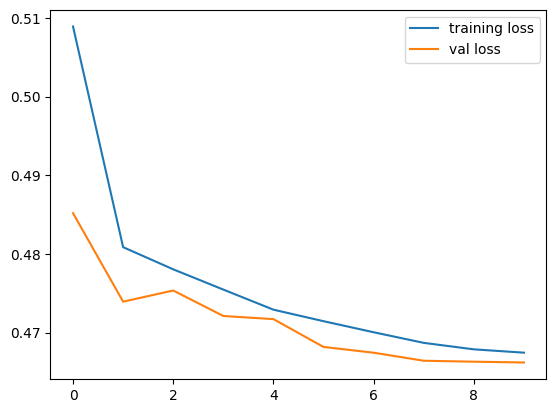

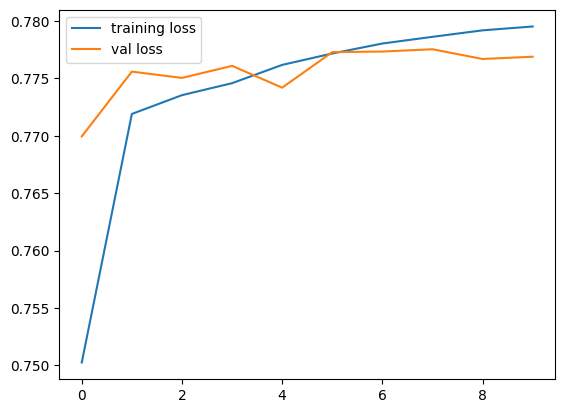

In [5]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=N_EPOCHS)

# evaluate the model
metrics_val = model.evaluate(val_dataset)
metrics_train = model.evaluate(train_dataset)

print("Validation: ", metrics_val)
print("Train: ", metrics_train)

# draw the learning curves
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['binary_accuracy'], label='training loss')
plt.plot(history.history['val_binary_accuracy'], label='val loss')
plt.legend()
plt.show()

## draw predictions
def pick_data(data, label):
    return data

def pick_sig(data, label):
    return label == 1
    
def pick_bkg(data, label):
    return label == 0




10/10 [==============================] - 1s 53ms/step


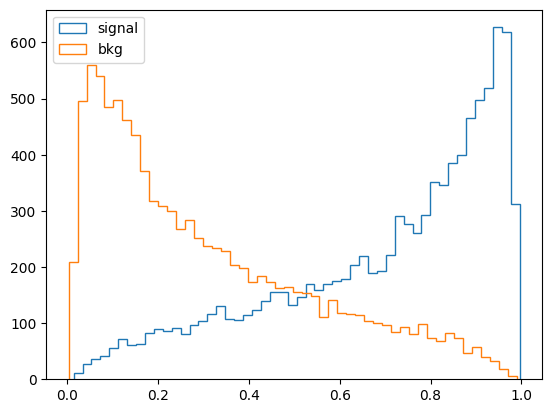

In [6]:
sig_data = val_dataset.unbatch()
sig_data = sig_data.filter(pick_sig)
sig_data = sig_data.map(pick_data)
sig_data = sig_data.ragged_batch(BATCH_SIZE)

bkg_data = val_dataset.unbatch()
bkg_data = bkg_data.filter(pick_bkg)
bkg_data = bkg_data.map(pick_data)
bkg_data = bkg_data.ragged_batch(BATCH_SIZE)

prediction_sig = model.predict(sig_data)
prediction_bkg = model.predict(bkg_data)

plt.hist(prediction_sig, bins=50, histtype='step', label='signal')
plt.hist(prediction_bkg, bins=50, histtype='step', label='bkg')
plt.legend()
plt.show()